In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random

In [28]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)  

In [3]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,X,Y,Z,A0,A1,A2,A5,A6,A7
0,0.000000,-0.759297,0.419074,3.31,2.01,0.0,1.94,1.58,1.65
1,0.058824,-0.759205,0.418863,3.39,2.23,0.0,2.09,1.73,1.80
2,0.117647,-0.759242,0.419042,3.46,2.16,0.0,2.09,1.80,1.87
3,0.176471,-0.759302,0.419248,3.67,2.30,0.0,2.23,1.87,1.94
4,0.235294,-0.759177,0.418970,3.82,2.30,0.0,2.16,1.87,1.94


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10708 entries, 0 to 10707
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       10708 non-null  float64
 1   Y       10708 non-null  float64
 2   Z       10708 non-null  float64
 3   A0      10708 non-null  float64
 4   A1      10708 non-null  float64
 5   A2      10708 non-null  float64
 6   A5      10708 non-null  float64
 7   A6      10708 non-null  float64
 8   A7      10708 non-null  float64
dtypes: float64(9)
memory usage: 753.0 KB


In [5]:
X, y = dataset[["X", "Y", "Z"]], dataset[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

x_mean = X.iloc[:, 0].mean()

x_std = X.iloc[:, 0].std()
y_mean = X.iloc[:, 1].mean()
y_std = X.iloc[:, 1].std()
z_mean = X.iloc[:, 2].mean()
z_std = X.iloc[:, 2].std()

# Normalize each column
X_norm = np.copy(X)
X_norm[:, 0] = (X.iloc[:, 0] - x_mean) / x_std
X_norm[:, 1] = (X.iloc[:, 1] - y_mean) / y_std
X_norm[:, 2] = (X.iloc[:, 2] - z_mean) / z_std

y_norm = y / 73.8

In [6]:
X_norm = torch.tensor(pd.DataFrame(X_norm).values, dtype=torch.float32)
y_norm = torch.tensor(pd.DataFrame(y_norm).values, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
X_train

tensor([[-0.9425,  0.6090,  1.6928],
        [-0.7765,  1.6047,  0.8203],
        [ 1.5648, -0.5537,  0.8535],
        ...,
        [-0.1568, -0.2147, -1.0535],
        [-1.2321, -1.6867,  0.6647],
        [ 0.6153,  0.3961,  0.7643]])

In [8]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class LinearlyActuatedStruts(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStruts, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
    def forward(self, x):
        return self.model(x)

In [35]:
model = LinearlyActuatedStruts()  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 170

train_losses = []
val_losses = []
counter = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if counter % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    counter += 1

Epoch 10/170 | Train Loss: 0.0012 | Val Loss: 0.0012
Epoch 20/170 | Train Loss: 0.0007 | Val Loss: 0.0006
Epoch 30/170 | Train Loss: 0.0006 | Val Loss: 0.0006
Epoch 40/170 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 50/170 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 60/170 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 70/170 | Train Loss: 0.0003 | Val Loss: 0.0005
Epoch 80/170 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 90/170 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 100/170 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 110/170 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 120/170 | Train Loss: 0.0002 | Val Loss: 0.0003
Epoch 130/170 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 140/170 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 150/170 | Train Loss: 0.0002 | Val Loss: 0.0003
Epoch 160/170 | Train Loss: 0.0002 | Val Loss: 0.0003
Epoch 170/170 | Train Loss: 0.0002 | Val Loss: 0.0002


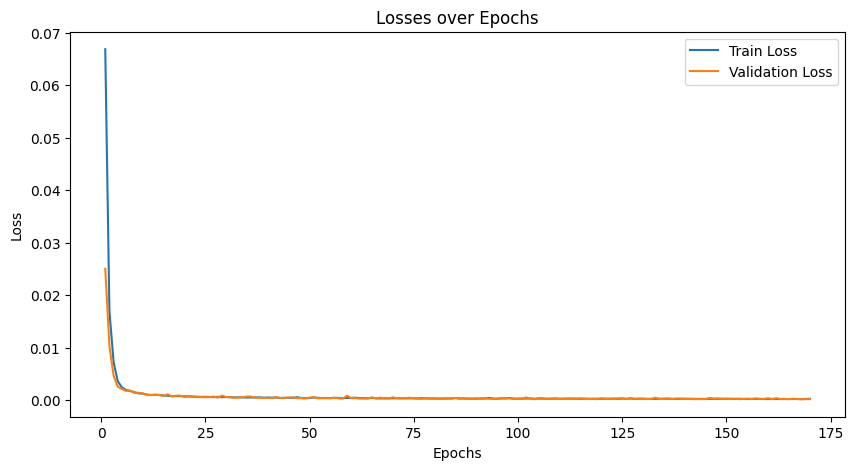

In [36]:
def plot_losses(train_loss, val_loss):
    epochs = np.arange(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(train_losses, val_losses)

In [37]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Rescale predictions back to [0, 73.8]
pred_real = predictions * 73.8

In [38]:
y_test_scaled = y_test * 73.8
pred_real = torch.round(pred_real, decimals=2)
print(pred_real)

tensor([[7.3710e+01, 7.3800e+01, 7.3730e+01, 1.1100e+00, 2.0000e-02, 6.8750e+01],
        [1.0000e-02, 2.5000e-01, 5.8470e+01, 6.0000e-02, 4.8390e+01, 4.0000e-02],
        [4.9540e+01, 3.0040e+01, 3.9000e-01, 1.6960e+01, 2.4200e+01, 2.4650e+01],
        ...,
        [7.3450e+01, 7.3750e+01, 7.3680e+01, 5.6570e+01, 1.2000e-01, 3.0000e-02],
        [7.3750e+01, 7.3670e+01, 7.3770e+01, 3.7000e-01, 7.3650e+01, 5.3040e+01],
        [7.3710e+01, 7.0260e+01, 1.6000e-01, 4.3320e+01, 6.7170e+01, 5.6660e+01]])


In [39]:
print(y_test_scaled)

tensor([[73.4300, 73.3600, 73.2900,  0.0000,  0.0000, 69.4700],
        [ 0.0000,  0.0000, 57.5600,  0.0000, 48.9800,  0.0000],
        [49.2700, 28.4200,  0.0000, 16.8800, 24.0200, 23.3700],
        ...,
        [73.8000, 73.7200, 73.8000, 54.3900,  0.0000,  0.0000],
        [73.8000, 73.8000, 73.8000,  0.0000, 73.8000, 54.6100],
        [73.5800, 71.1300,  0.0000, 44.6500, 67.7400, 56.7000]])


In [40]:
# Calculate the mean absolute error
mae = torch.mean(torch.abs(pred_real - y_test_scaled))
print(f'Mean Absolute Error: {mae.item():.4f}')

Mean Absolute Error: 0.5610
